************************************************************************************
Digite o tempo em segundos (padrão 4s): 
Digite o valor do passo (padrão 0.0001): 
Digite a frequência cardiaca (padrão 60): 
Elastância máxima (padrão 2): 
************************************************************************************


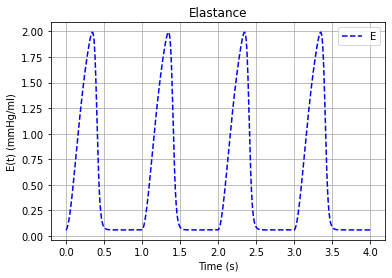

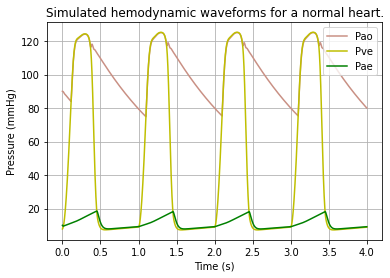

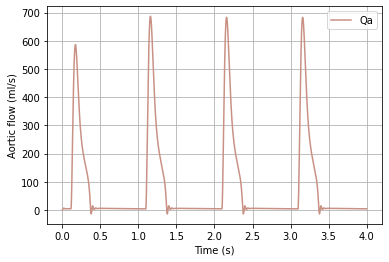

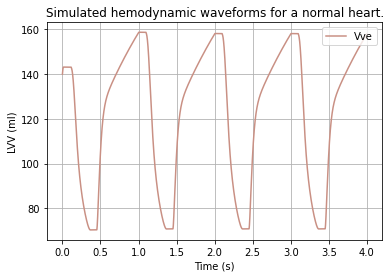

In [1]:
import io, os, sys, types
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# %matplotlib inline
# %config InlineBackend.figure_format='svg'
# import pylab
# pylab.rcParams['figure.figsize'] = (8, 8)
# %config InlineBackend.figure_format='retina'

# %run simaan2008 #import class simaan2008 


class Simaan2008():
    def __init__(self):
        self.start_t = 0 
        self.step   = 0.0001
        self.end_t   = 3
            
            
        self.T = list(np.arange(self.start_t,self.end_t,self.step)) #
        self.n = len(self.T)

        #Cardiovascular System
        self.HR   = 60
        self.Emax = 2.5 #elastance amplitude
        self.Emin = 0.06
        self.tc   = 60/self.HR #cardiac cycle

        self.t_max = 0.2 + 0.15*self.tc; #max time cardiac cycle
        self.E = self.elastance(self.T) #normalized elastance


            
        self.Rs  = 1.0000 #vascular resistence
        self.Rm  = 0.0050 #mitral resistence
        self.Cae = 4.4000 #artic elastance
        self.Ra  = 0.0010 #aortic resistence
        self.Rc  = 0.0398 
        self.Cs  = 1.3300 #Elastance system
        self.Cao = 0.0800 #Elastance aortic
        self.Ls  = 0.0005 

        self.Vo = 10 #Initial Pressure

        self.Pao = np.zeros_like(self.T) #aortic pressure
        self.Qa  = np.zeros_like(self.T) #aortic flow
        self.Vve = np.zeros_like(self.T) #left ventricle
        self.Pas = np.zeros_like(self.T) #aortic pressure system
        self.Pae = np.zeros_like(self.T) #left artic pressure
        self.Pve = np.zeros_like(self.T) #left ventricle pressure
        self.Dm_ = np.zeros_like(self.T) 
        self.Da_ = np.zeros_like(self.T) 


        #Initial Conditions
        self.Pao[0] =  90
        self.Qa[0]  =   0
        self.Vve[0] = 140 #Left ventricular volume
        self.Pas[0] =  90
        self.Pae[0] =  10

        self.Pve[0] = self.E[0]* (self.Vve[0] - self.Vo) #Left ventricular pressure

        self.x = np.transpose([self.Pao[0], self.Qa[0], self.Vve[0], self.Pas[0], self.Pae[0]])

        #Initial States of diodes
        self.Dm = 0
        self.Da = 0



        #Parameters
    def parameters(self,start_t, end_t, step, HRs, Emaxs):
 
        self.start_t = start_t 
        self.step   = step
        self.end_t   = end_t
            

        #time scale used
        self.T = list(np.arange(self.start_t,self.end_t,self.step)) #
        self.n = len(self.T)

        #Cardiovascular System
        self.HR   = HRs
        self.Emax = Emaxs #elastance amplitude
        self.Emin = 0.06
        self.tc   = 60/self.HR #cardiac cycle

        self.t_max = 0.2 + 0.15*self.tc; #max time cardiac cycle
        self.E = self.elastance(self.T) #normalized elastance


            
        self.Rs  = 1.0000 #vascular resistence
        self.Rm  = 0.0050 #mitral resistence
        self.Cae = 4.4000 #artic elastance
        self.Ra  = 0.0010 #aortic resistence
        self.Rc  = 0.0398 
        self.Cs  = 1.3300 #Elastance system
        self.Cao = 0.0800 #Elastance aortic
        self.Ls  = 0.0005 

        self.Vo = 10 #Initial Pressure

        self.Pao = np.zeros_like(self.T) #aortic pressure
        self.Qa  = np.zeros_like(self.T) #aortic flow
        self.Vve = np.zeros_like(self.T) #left ventricle
        self.Pas = np.zeros_like(self.T) #aortic pressure system
        self.Pae = np.zeros_like(self.T) #left artic pressure
        self.Pve = np.zeros_like(self.T) #left ventricle pressure
        self.Dm_ = np.zeros_like(self.T) 
        self.Da_ = np.zeros_like(self.T) 


        #Initial Conditions
        self.Pao[0] =  90
        self.Qa[0]  =   0
        self.Vve[0] = 140 #Left ventricular volume
        self.Pas[0] =  90
        self.Pae[0] =  10

        self.Pve[0] = self.E[0]* (self.Vve[0] - self.Vo) #Left ventricular pressure

        self.x = np.transpose([self.Pao[0], self.Qa[0], self.Vve[0], self.Pas[0], self.Pae[0]])

        #Initial States of diodes
        self.Dm = 0
        self.Da = 0
        return

    def elastance(self, t):

        tn = np.asarray(t)%self.tc/self.t_max;
        En = 1.55 * np.power(np.asarray(tn)/.7, 1.9) / (1 + np.power(np.asarray(tn)/.7, 1.9)) \
        / (1 + np.power(np.asarray(tn)/1.17, 21.9))
        return (self.Emax-self.Emin)*En + self.Emin
    
    def rugkut4(self,step,A,x,B,i):
        
        Ar = np.array(A);
        xr = np.array(x);
        Br = np.array(B);

        xdot = np.matmul(Ar, xr) + Br;
        kx1 = step*xdot

        x1 = x + 0.5*kx1
        xdot = np.matmul(Ar, x1) + Br
        kx2 = step*xdot

        x1 = x + 0.5*kx2
        xdot = np.matmul(Ar, x1) + Br
        kx3 = step*xdot

        x1 = x + kx3
        xdot = np.matmul(Ar, x1) + Br
        kx4 = step*xdot

        value = np.asarray(x + (kx1 + 2*kx2 + 2*kx3 + kx4)/6)

        return value



def simulation(time, step, HR, Emax):
    #Simulation start
    simaan = Simaan2008()
    parameters=simaan.parameters(0, time, step, HR, Emax) #Simulation Time

    for i in range(simaan.n-1):

        #ramp function
        if simaan.Pae[i] >= simaan.Pve[i]:
            simaan.Dm = 1
        else:
            simaan.Dm = 0

        if simaan.Pve[i] >= simaan.Pao[i]:
            simaan.Da = 1
        else:
            simaan.Da = 0

        a13 = (simaan.Da)/(simaan.Ra) * (simaan.E[i])
        a33 = -(((simaan.Dm)/(simaan.Rm)) + ((simaan.Da)/(simaan.Ra)))*simaan.E[i]
        a53 = (simaan.Dm)/(simaan.Rm) * simaan.E[i]
        a55 = -((1/(simaan.Rs))+((simaan.Dm)/(simaan.Rm)))

        A = [[0], [0], [0], [0],[0]];
        A[0] = [-((simaan.Da)/(simaan.Ra)), -1, a13, 0, 0]/np.array(simaan.Cao)
        A[1] = [1, -(simaan.Rc), 0, -1, 0]/np.array(simaan.Ls)
        A[2] = [(simaan.Da)/(simaan.Ra), 0, a33, 0, (simaan.Dm)/(simaan.Rm)]
        A[3] = [0, 1, 0, -1/(simaan.Rs), 1/(simaan.Rs)]/np.array(simaan.Cs);
        A[4] = [0, 0, a53, 1/(simaan.Rs), a55]/np.array(simaan.Cae);


        B = [-(((simaan.Da)/(simaan.Ra))*simaan.E[i]*simaan.Vo)/simaan.Cao,
             0,
             ((simaan.Dm)/(simaan.Rm) + (simaan.Da)/(simaan.Ra))*simaan.E[i]*simaan.Vo,
             0,
             ( -((simaan.Dm)/(simaan.Rm))*simaan.E[i]*simaan.Vo)/simaan.Cae]

        simaan.x =  simaan.rugkut4(simaan.step, A, simaan.x, B,i)

        simaan.Pao[i+1] =  simaan.x[0]
        simaan.Qa[i+1]  =  simaan.x[1]
        simaan.Vve[i+1] =  simaan.x[2]
        simaan.Pas[i+1] =  simaan.x[3]
        simaan.Pae[i+1] =  simaan.x[4]
        simaan.Pve[i+1] = simaan.E[i+1] * (simaan.Vve[i+1] - simaan.Vo)
    print("************************************************************************************")
    plt.plot(simaan.T, simaan.E, 'b--', label="E" )
    plt.title('Elastance')
    plt.xlabel('Time (s)')
    plt.ylabel('E(t) (mmHg/ml)')
    plt.legend(loc="upper right")
    plt.grid()
    plt.show()


    plt.plot(simaan.T, simaan.Pao, '#C99084', label="Pao" )
    plt.plot(simaan.T, simaan.Pve, 'y', label="Pve" )
    plt.plot(simaan.T, simaan.Pae, 'g', label="Pae" )
    plt.title('Simulated hemodynamic waveforms for a normal heart.')
    plt.xlabel('Time (s)')
    plt.ylabel('Pressure (mmHg)')
    plt.legend(loc="upper right")
    plt.grid()
    plt.show()

    
    plt.plot(simaan.T, simaan.Qa, '#C99084', label="Qa" )
    plt.xlabel('Time (s)')
    plt.ylabel('Aortic flow (ml/s)')
    plt.legend(loc="upper right")
    plt.grid()
    plt.show()

    
    plt.plot(simaan.T, simaan.Vve, '#C99084', label="Vve" )
    plt.title('Simulated hemodynamic waveforms for a normal heart.')
    plt.xlabel('Time (s)')
    plt.ylabel('LVV (ml)')
    plt.legend(loc="upper right")
    plt.grid()
    plt.show()

print("************************************************************************************")
time = input('Digite o tempo em segundos (padrão 4s): ') or 4
step = input('Digite o valor do passo (padrão 0.0001): ') or 0.0001
HR   = input('Digite a frequência cardiaca (padrão 60): ') or 60
Emax = input('Elastância máxima (padrão 2): ') or 2

# simulation(time, step, int(HR), float(Emax))
simulation(4,0.0001, 60, 2.0)
